<a href="https://colab.research.google.com/github/pethodoma/BME-DeepLearning-BirdCLEF_2023/blob/main/Milestone2_Bird_Unet_with_data_loader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#! pip uninstall tensorflow tensorflow-io tensorflow_io

In [1]:
# install older version to read audio files with tensorflow_io
!pip install tensorflow==2.13.0
!pip install tensorflow-io==0.34.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 96.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 109.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 33.7 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Uninstalling gast-0.5.4:
      Successfully uninstalled gast-0.5.4
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import librosa
import os
import gdown
from google.colab import drive
from sklearn.preprocessing import OneHotEncoder
import tensorflow_io as tfio
from sklearn.model_selection import train_test_split


First we go through directory containing the train audio files and save their paths in a list for later use. After that we sort the list because the os.walk function don't keep the order of the files. The files are in alphabetical order in the metadata csv file by the IDs of the birds and we want to save the paths in same order making it easier to handle.

Then we define preprocessing that can load wav files and can create the spectrograms from them. We have a unique preprocess function for the autoencoder part that needs the spectrograms as labels

In [3]:
def read_file_paths(main_dictionary):
    main_directory = main_dictionary
    file_paths = []

    # go through all folders and get the paths of all .ogg audio files
    for root, directories, files in os.walk(main_directory):
        for file in files:
            if file.endswith('.ogg') or file.endswith('.wav'):
                file_path = os.path.join(root, file)
                file_paths.append(file_path)

    # os.walk may not go in alphabetical order thus it needs to be sorted
    file_paths.sort()
    return file_paths

In [4]:
# Preprocessing functions for the data pipeline
# Loading the wavfiles
def load_wav_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    return wav

# Converting the wavfiles to melspectrograms
def preprocess(file_path, label):
    wav = load_wav_mono(file_path)
    wav = wav[:160000]    # Making sure it is not longer than 5 seconds
    spectrogram = tf.signal.stft(wav, frame_length=1024, frame_step=524)  # Fourier-transform
    spectrogram = tf.abs(spectrogram)
    melspec = tfio.audio.melscale(spectrogram, 32000, 128, 500, 16000)    # Converting to the mel-scale
    melspec_dB = 10 * tf.math.log(melspec**2)                             # Converting power to decibels
    melspec_dB = tf.transpose(melspec_dB)
    melspec_dB = tf.expand_dims(melspec_dB, axis=2)                       # Expanding dimensions so that it can be fed to the neural network
    return melspec_dB, label

def preproc_encode(file_path, label):
    melspec_dB,label = preprocess(file_path,label)
    return melspec_dB, melspec_dB

We download the 5 sec long wav files containing the bird chirps with some noise. Then we create a pandas dataframe to handle the labels (the bird species) easier

In [5]:
# Download the wav files
!wget -O training_files.zip https://www.dropbox.com/scl/fi/2yogrqyao6uypiwtbv8mc/file.zip?rlkey=e3bdpmjvfios021zxlo1ru3b4&dl=0
!wget -O sample_submission.csv https://www.dropbox.com/scl/fi/f226hzkwvm1t3xix5xb08/sample_submission.csv?rlkey=hw58elmc6868h4tmk7gqq2i8t&dl=0

--2023-11-27 23:02:54--  https://www.dropbox.com/scl/fi/2yogrqyao6uypiwtbv8mc/file.zip?rlkey=e3bdpmjvfios021zxlo1ru3b4
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucaca9a44049cc30d3bea28f57ad.dl.dropboxusercontent.com/cd/0/inline/CIXDkrheUTvc2QRJoWRaV-nqa9N8j-P_QYgDZZKBN18Jy4830gqoTfeIsB6455x_4FnoTKVBsJj8fcYKFTlwpqMX2eUePU0dhawpNBmBEn_GN-6fafj9L5yXbVbluV2ur8dCSaO4za-i93O3X5uabGH7/file# [following]
--2023-11-27 23:02:55--  https://ucaca9a44049cc30d3bea28f57ad.dl.dropboxusercontent.com/cd/0/inline/CIXDkrheUTvc2QRJoWRaV-nqa9N8j-P_QYgDZZKBN18Jy4830gqoTfeIsB6455x_4FnoTKVBsJj8fcYKFTlwpqMX2eUePU0dhawpNBmBEn_GN-6fafj9L5yXbVbluV2ur8dCSaO4za-i93O3X5uabGH7/file
Resolving ucaca9a44049cc30d3bea28f57ad.dl.dropboxusercontent.com (ucaca9a44049cc30d3bea28f57ad.dl.dropboxusercontent.com)... 162.125.81.15, 2620:1

In [6]:
!unzip training_files.zip

A streamkimeneten csak az utolsó 5000 sor látható.
  inflating: wavfiles/whbtit5/whbtit5_110495.wav  
  inflating: wavfiles/whbtit5/whbtit5_110472.wav  
   creating: wavfiles/moccha1/
  inflating: wavfiles/moccha1/moccha1_75146.wav  
  inflating: wavfiles/moccha1/moccha1_75065.wav  
  inflating: wavfiles/moccha1/moccha1_74888.wav  
  inflating: wavfiles/moccha1/moccha1_75042.wav  
  inflating: wavfiles/moccha1/moccha1_75399.wav  
  inflating: wavfiles/moccha1/moccha1_75360.wav  
  inflating: wavfiles/moccha1/moccha1_75192.wav  
  inflating: wavfiles/moccha1/moccha1_75303.wav  
  inflating: wavfiles/moccha1/moccha1_74947.wav  
  inflating: wavfiles/moccha1/moccha1_75176.wav  
  inflating: wavfiles/moccha1/moccha1_75278.wav  
  inflating: wavfiles/moccha1/moccha1_74897.wav  
  inflating: wavfiles/moccha1/moccha1_74877.wav  
  inflating: wavfiles/moccha1/moccha1_74989.wav  
  inflating: wavfiles/moccha1/moccha1_74925.wav  
  inflating: wavfiles/moccha1/moccha1_74988.wav  
  inflating: wav

In [7]:
# read wav files and create dataframe for the filepath - bird species pairs
filepaths = read_file_paths('wavfiles')
training_files_df = pd.DataFrame(filepaths, columns=['filepath'])
training_files_df['bird'] = training_files_df['filepath'].apply(lambda x: x.split(os.path.sep)[-1].split('_')[-2])
training_files_df

,filepath,bird
0,wavfiles/abethr1/abethr1_10.wav,abethr1
1,wavfiles/abethr1/abethr1_11.wav,abethr1
2,wavfiles/abethr1/abethr1_13.wav,abethr1
3,wavfiles/abethr1/abethr1_14.wav,abethr1
4,wavfiles/abethr1/abethr1_17.wav,abethr1
...,...,...
13095,wavfiles/yewgre1/yewgre1_122531.wav,yewgre1
13096,wavfiles/yewgre1/yewgre1_122537.wav,yewgre1
13097,wavfiles/yewgre1/yewgre1_122538.wav,yewgre1
13098,wavfiles/yewgre1/yewgre1_122557.wav,yewgre1


In [8]:
# Let's see if wa have managed to extract chirps from all the birds.
unique_birds = training_files_df['bird'].unique()
print(len(unique_birds))
bird_categories_df = pd.read_csv('sample_submission.csv').transpose().reset_index().tail(-1).drop(columns=[0,1,2])
bird_categories_df.columns = ['bird']
# It looks like there are two bird species we haven't managed to extract any chirps from. We throw these away from the possibilities
bird_categories_df = bird_categories_df[bird_categories_df['bird'].isin(unique_birds)]
bird_categories_df

262


,bird
1,abethr1
2,abhori1
3,abythr1
4,afbfly1
5,afdfly1
...,...
260,yertin1
261,yesbar1
262,yespet1
263,yetgre1


In [9]:
# Fitting the onehotencoder on the bird categories
onehotencoder = OneHotEncoder(sparse_output=False)
onehotencoder.fit(bird_categories_df)

OneHotEncoder(sparse_output=False)

In [10]:
Y = onehotencoder.transform(pd.DataFrame(training_files_df['bird'], columns=['bird']))
Y.shape

(13100, 262)

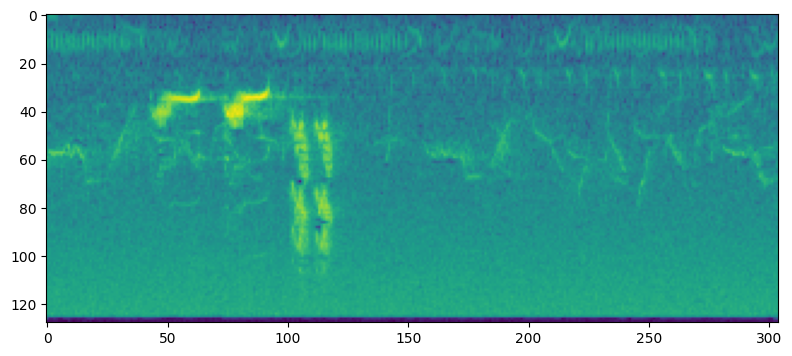

(128, 304, 1)


In [11]:
# Print the shape of- and show the spectrogram to check the load process
specgram, _ = preprocess('wavfiles/abethr1/abethr1_11.wav', _)
plt.figure(figsize=(12, 4))
plt.imshow(specgram)
plt.show()
print(specgram.shape)

We create tensorflow datasets to handle train-, validation- and test data. Datasets make it easier to split the data in the 3 groups while keeping attention to the classes. With the stratify parameter it makes bird species to appear in every group with the same percentage. We make a unique dataframe to the autoencoder like mentioned above.

In [12]:
filepaths_train, filepaths_temp, Y_train, Y_temp = train_test_split(filepaths, Y, test_size=0.3, random_state=42, stratify=Y)
filepaths_val, filepaths_test, Y_val, Y_test = train_test_split(filepaths_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp)

In [13]:
train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(filepaths_train), tf.data.Dataset.from_tensor_slices(Y_train)))
val_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(filepaths_val), tf.data.Dataset.from_tensor_slices(Y_val)))
test_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(filepaths_test), tf.data.Dataset.from_tensor_slices(Y_test)))

In [14]:
encoder_train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(filepaths_train), tf.data.Dataset.from_tensor_slices(filepaths_train)))
encoder_val_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(filepaths_val), tf.data.Dataset.from_tensor_slices(filepaths_val)))
encoder_test_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(filepaths_test), tf.data.Dataset.from_tensor_slices(filepaths_test)))

In [ ]:
#asd = tf.data.Dataset.from_tensor_slices(filepaths_train)
#vmi = tf.data.Dataset.zip(asd,asd)
#dsa = vmi.map(preproc_encode)
#print(dsa.element_spec)

In [ ]:
#print(filepaths_test[:10])

In [15]:
train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)
print(f'Train dataset size: {tf.data.experimental.cardinality(train_dataset).numpy()}\nTest dataset size: {tf.data.experimental.cardinality(test_dataset).numpy()}\nValidation dataset size: {tf.data.experimental.cardinality(val_dataset).numpy()}')

Train dataset size: 9170
Test dataset size: 1965
Validation dataset size: 1965


In [16]:
encoder_train_dataset = encoder_train_dataset.map(preproc_encode)
encoder_val_dataset = encoder_val_dataset.map(preproc_encode)
encoder_test_dataset = encoder_test_dataset.map(preproc_encode)
print(f'Train dataset size: {tf.data.experimental.cardinality(encoder_train_dataset).numpy()}\nTest dataset size: {tf.data.experimental.cardinality(encoder_test_dataset).numpy()}\nValidation dataset size: {tf.data.experimental.cardinality(encoder_val_dataset).numpy()}')

Train dataset size: 9170
Test dataset size: 1965
Validation dataset size: 1965


In [17]:
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [18]:
batch_size = 32
encoder_train_dataset = encoder_train_dataset.shuffle(buffer_size=10000).batch(batch_size)
encoder_val_dataset = encoder_val_dataset.batch(batch_size)
encoder_test_dataset = encoder_test_dataset.batch(batch_size)

In [ ]:
#model = tf.keras.models.Sequential()
#model.add(tf.keras.layers.Conv2D(16, (5,5), activation='relu', input_shape=(128, 311, 1)))
#model.add(tf.keras.layers.Conv2D(16, (5,5), activation='relu'))
#model.add(tf.keras.layers.Flatten())
#model.add(tf.keras.layers.Dense(320, activation='relu'))
#model.add(tf.keras.layers.Dense(262, activation='softmax'))

In [ ]:
#model.compile('Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#model.summary()

In [ ]:
#hist = model.fit(train_dataset, epochs=10, validation_data=test_dataset)

In [19]:
encoder_test_dataset.element_spec

(TensorSpec(shape=(None, 128, None, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, None, 1), dtype=tf.float32, name=None))

Create the autoencoder U-net model. This model uses conv2d and conv2dTranspose layers to learn the features of the spectrograms. Skip connections between the same level of the encoder part and the decoder part makes it more efficient.

After we trained the U-net model we cut the decoder part off the model. Then Dense layers will make the classification according to the vectors given by the encoder part with all its learned features.

In [20]:
# The encoder part is built up from blocks defined here
# This block make a convolution and then it halves the dimension of the input image sizes
def encoder_block(inputs, num_filters):

    x = tf.keras.layers.Conv2D(num_filters,kernel_size=(3,3), padding='same')(inputs)
    x = tf.keras.layers.MaxPool2D(pool_size=2)(x)

    return x

In [21]:
# The decoder part is built up from blocks defined here
# This block make a conv2dTransposeto double the sizes of the input image
# Then it concatenates the output from the encoder part of the model doubling the depth
# Finally it makes a convoluion to half the depth returning it to the state before the concatenation
def decoder_block(inputs, skip_features, num_filters):

    # Upsampling with 2x2 filter
    x = tf.keras.layers.Conv2DTranspose(num_filters,
                                        (2, 2),
                                        strides = 2,
                                        padding = 'same')(inputs)

    skip_features = tf.image.resize(skip_features,
                                    size = (x.shape[1],
                                            x.shape[2]))
    x = tf.keras.layers.Concatenate()([x, skip_features])

    # Convolution with 3x3 filter followed by ReLU activation
    x = tf.keras.layers.Conv2D(num_filters,
                               3,
                               padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)


    return x

In [22]:
# Creating Unet code


def unet_model(input_shape = (256, 256, 3), num_classes = 1):
    inputs = tf.keras.Input(input_shape)

    # Contracting Path
    s1 = encoder_block(inputs, 16)
    s2 = encoder_block(s1, 32)
    s3 = encoder_block(s2, 64)
    #s4 = encoder_block(s3, 512)

    # Bottleneck
    b1 = tf.keras.layers.Conv2D(64, 3, padding = 'same')(s3)
    b1 = tf.keras.layers.Activation('relu')(b1)
    b1 = tf.keras.layers.Conv2D(64, 3, padding = 'same')(b1)
    b1 = tf.keras.layers.Activation('relu')(b1)

    # Expansive Path
    #s5 = decoder_block(b1, s4, 512)
    s6 = decoder_block(b1, s3, 64)
    s7 = decoder_block(s6, s2, 32)
    s8 = decoder_block(s7, s1, 16)

    # Output
    outputs = tf.keras.layers.Conv2D(num_classes,
                                     1,
                                     padding = 'same',
                                     activation = 'tanh')(s8)

    model = tf.keras.models.Model(inputs = inputs,
                                  outputs = outputs,
                                  name = 'U-Net')
    return model

In [23]:
# Define U-net model with 1 class to make the exact same picture with one channel
input_shape = (128,304,1)
num_classes = 1
model = unet_model(input_shape=input_shape, num_classes=num_classes)
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 304, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 304, 16)         160       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 152, 16)          0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 152, 32)          4640      ['max_pooling2d[0][0]']   

In [ ]:
#def extract_inputs(inputs, labels):
#    return inputs

In [ ]:
#X_train_dataset = train_dataset.map(extract_inputs)
#X_val_dataset = val_dataset.map(extract_inputs)

In [ ]:
#sample_size = 5
#sample_X = next(iter(X_train_dataset.take(sample_size)))

In [ ]:
#in_numpy = sample_X.numpy()
#print(in_numpy.shape)

In [24]:
# Teaching the autoencoder part
model.fit(encoder_train_dataset,epochs=20,batch_size=256,validation_data=(encoder_val_dataset))

Epoch 1/20
287/287 [==============================] - 38s 36ms/step - loss: 3978.9109 - accuracy: 8.4075e-09 - val_loss: 4059.2290 - val_accuracy: 1.3078e-08
Epoch 2/20
287/287 [==============================] - 26s 31ms/step - loss: 3977.0234 - accuracy: 5.6050e-09 - val_loss: 4059.1570 - val_accuracy: 1.3078e-08
Epoch 3/20
287/287 [==============================] - 26s 31ms/step - loss: 3976.9636 - accuracy: 8.4075e-09 - val_loss: 4059.0996 - val_accuracy: 1.3078e-08
Epoch 4/20
287/287 [==============================] - 26s 31ms/step - loss: 3976.9155 - accuracy: 8.4075e-09 - val_loss: 4059.0647 - val_accuracy: 1.3078e-08
Epoch 5/20
287/287 [==============================] - 26s 31ms/step - loss: 3976.8928 - accuracy: 8.4075e-09 - val_loss: 4059.0486 - val_accuracy: 1.3078e-08
Epoch 6/20
287/287 [==============================] - 26s 31ms/step - loss: 3976.8760 - accuracy: 8.4075e-09 - val_loss: 4059.0315 - val_accuracy: 1.3078e-08
Epoch 7/20
287/287 [==============================] 

In [ ]:
#decoded_imgs = model.predict(X_test)

In [ ]:
#import matplotlib.pyplot as plt
#
## eredeti és visszaállított képek kirajzolása
#n = 8
#plt.figure(figsize=(16, 4))
#for i in range(n):
#  # eredeti
#  ax = plt.subplot(2, n, i + 1)
#  ax.set_title('eredeti')
#  plt.imshow(X_test[i*5].reshape(128,312))
#  plt.gray()
#
#  # visszaállított
#  ax = plt.subplot(2, n, i + 1 + n)
#  ax.set_title('visszaállított')
#  plt.imshow(decoded_imgs[i*5].reshape(128,312))
#  plt.gray()

In [25]:
# Getting the input and encoder layers of the U-net model
import keras
input_layer = keras.Input(shape=input_shape)
encoder_layer = input_layer
#enc = []
for i in range(1,9):
    encoder_layer = model.get_layer(index=i)(encoder_layer)
    #enc.append(input_layer)

In [26]:
# Make the classification model from the encoder part with dense layers
from keras.optimizers import SGD, Adam

num_classes = 262

flatten = keras.layers.Flatten()(encoder_layer)
dense = keras.layers.Dense(256,activation='relu')(flatten)
dense = keras.layers.Dense(num_classes,activation='softmax')(dense)
class_model = keras.models.Model(inputs=input_layer,outputs=dense)
class_model.summary()
class_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 304, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 304, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 152, 16)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 152, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 76, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 76, 64)        18496 

In [ ]:
#from keras.utils import to_categorical
#y_train = to_categorical(y_train,num_classes=num_classes)
#y_valid = to_categorical(y_valid,num_classes=num_classes)
#y_test = to_categorical(y_test,num_classes=num_classes)

In [27]:
# Teaching the classification model
class_model.fit(train_dataset,epochs=10,batch_size=256,validation_data=(val_dataset))

Epoch 1/10
287/287 [==============================] - 26s 21ms/step - loss: 6.2591 - accuracy: 0.0040 - val_loss: 5.4579 - val_accuracy: 0.0092
Epoch 2/10
287/287 [==============================] - 23s 20ms/step - loss: 5.3227 - accuracy: 0.0168 - val_loss: 5.1817 - val_accuracy: 0.0336
Epoch 3/10
287/287 [==============================] - 23s 21ms/step - loss: 6.9836 - accuracy: 0.0264 - val_loss: 5.5692 - val_accuracy: 0.0036
Epoch 4/10
287/287 [==============================] - 23s 21ms/step - loss: 5.5702 - accuracy: 0.0029 - val_loss: 5.5690 - val_accuracy: 0.0036
Epoch 5/10
287/287 [==============================] - 23s 20ms/step - loss: 5.5700 - accuracy: 0.0021 - val_loss: 5.5689 - val_accuracy: 0.0036
Epoch 6/10
287/287 [==============================] - 23s 20ms/step - loss: 5.5700 - accuracy: 0.0026 - val_loss: 5.5688 - val_accuracy: 0.0036
Epoch 7/10
287/287 [==============================] - 23s 20ms/step - loss: 5.5699 - accuracy: 0.0032 - val_loss: 5.5688 - val_accuracy:

In [28]:
# Get predictions from the model
label_pred = class_model.predict(test_dataset)

62/62 [==============================] - 4s 60ms/step
